In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env THEANO_FLAGS=device=gpu3,floatX=float32

env: THEANO_FLAGS=device=gpu3,floatX=float32


In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 3 failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [4]:
#!mkdir sasha_rnn 
# !wget https://www.dropbox.com/s/fxbjs8gebdm7lkv/sp.json?dl=0 -O sp.json
# !wget https://www.dropbox.com/s/ongjlpx798h8ysq/tinytitles.txt?dl=0 -O tinytitles.txt
# !wget https://www.dropbox.com/s/fqhq3v7h1d67e4e/tokens.txt?dl=0 -O tokens.txt
# !wget https://www.dropbox.com/s/l72wr3fqk3wio44/weights_persona.pcl?dl=0 -O weights_persona.pcl
# !wget https://www.dropbox.com/s/pfg0lx5c17r68tw/weights.pcl?dl=0 -O weights.pkl
# !wget https://www.dropbox.com/s/6igoxt5cji02m5e/names_new.txt?dl=0 -O names_new.txt

# data

In [6]:
NAMES_FILENAME = "names_new.txt"
TOKENS_FILENAME = "tokens.txt"

In [7]:
with open(NAMES_FILENAME) as fin:
    names = list(filter(len, fin.read().split('\n')))

In [8]:
names[:10]

['dr._oz',
 'human_wendy',
 'whoopi',
 'kkk_leader',
 'an_official',
 'woodsy_owl',
 'captain',
 'ozzy',
 'geraldo',
 'male_anchor']

In [9]:
with open(TOKENS_FILENAME) as fin:
    tokens = list(filter(len, fin.read().split('\n'))) #[:33646]
  
tokens = tokens[:33646] + [name.strip('_').lower() for name in tokens[33646:]]


tokens.append("_BOS_") #beginning of sentence. Omitted in danet
tokens.append("_PAD_") #padding. Omitted in danet

#tokens += names

UNK_ix, BOS_ix, EOS_ix, PAD_ix = list(map(tokens.index, ["_UNK_","_BOS_","_EOS_","_PAD_"]))
n_tokens = len(tokens)

from collections import defaultdict
token_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(tokens)})

In [10]:
name_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(names)})

In [11]:
import regex
import numpy as np

def preprocess(lines, max_len=20, speaker=None, add_eos=True):
    if type(lines) == (str):
        lines = [lines]
    
    context=[]
    for line in lines:
        line = line.lower()
        line = regex.sub(r'(\p{P}|`|~)', r' \1 ', line)
        line_ix = list(map(token_to_ix.__getitem__, filter(len, line.split())))
        if add_eos:
            line_ix.append(EOS_ix)
        context += line_ix
            
    if speaker is not None:
        context.append(speaker)
        
    return context

def ix_to_matrix(phrases_ix, max_len=None):
    max_len = max_len or max(map(len,phrases_ix))
    
    matrix = np.zeros((len(phrases_ix),max_len),dtype='int32') + PAD_ix
    
    for i,phrase_ix in enumerate(phrases_ix):
        matrix[i,:min(len(phrase_ix),max_len)] = phrase_ix[:max_len]
        
    return matrix

def phrase_to_matrix(contexts, max_len=None, **kwargs):
            
    return ix_to_matrix([preprocess(phrases,**kwargs) for phrases in contexts], max_len=max_len)

In [12]:
len(tokens)

36071

In [13]:
phrase_to_matrix(["Hello dude!!!"])

array([[13885, 34723,    14,    14,    14,     0]], dtype=int32)

In [ ]:
def generate_data(data_rows, batch_size=32, speakers_list=None, context_length=3, max_len=20, n_iter=np.inf):
    i=0

    while True:
        batch_ix = np.random.randint(0, len(data_rows) - context_length - 1, batch_size)
        context_ix = batch_ix[:, None] + np.arange(context_length)[None, :]
        answer_ix = batch_ix + context_length
        batch_x = ix_to_matrix(list(map(np.concatenate, data_rows[context_ix])), max_len=max_len)
        batch_y = ix_to_matrix(data_rows[answer_ix], max_len=max_len)
        if speakers_list == None:
            yield batch_x, batch_y
        else:
            respondent = speakers_list[answer_ix]
            yield batch_x, batch_y, respondent
        i+=1
        if i >= n_iter:
            break

## Load data

In [ ]:
import json
from pprint import pprint

with open('sp.json', 'r') as fn:    
    data = json.load(fn, encoding='cp1251')
    
import re
numbers_regex = re.compile('#?[0-9]+')

def preprocess_speaker_name(name):
    try:
        str(name)
    except:
        return ''
    name_parts = map(str.lower, str(name).split())
    filtered = filter(lambda part: not re.match(numbers_regex, part), name_parts)
    return '_'.join(filtered)

data_rows = np.array([preprocess(lines=[phrase[1]])
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                      and len(phrase[0]) > 2])

speakers_list = np.array([name_to_ix[preprocess_speaker_name(phrase[0][:-2])]
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                          and len(phrase[0]) > 2])

# model

In [14]:
from warnings import warn
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T

In [15]:
theano.config.exception_verbosity='high'

In [16]:
grad_clipping = 5
lstm_units = 1024
emb_size = 512
bottleneck_units = 256
person_emb_size = 100
seq_len = 20
sampling_num = 5

temperature = theano.shared(np.float32(1.))


In [26]:
from sasha_rnn.wrong_lstm_layer import WrongLSTMLayer
from lasagne.layers import *

class encoder:
        
    input_phrase = T.imatrix("encoder phrase tokens")
    
    l_in = InputLayer((None,None), input_phrase, name='context input')
    l_mask = InputLayer((None,None), T.neq(input_phrase, PAD_ix), 'context mask')
    
    l_emb = EmbeddingLayer(l_in, n_tokens, emb_size, name="context embedding")
    
    
    ####LSTMLayer with incorrect outputgate####
    
    l_lstm = WrongLSTMLayer(
                        l_emb,
                        lstm_units,
                        name='encoder_lstm',
                        grad_clipping=grad_clipping,
                        mask_input=l_mask,
                        only_return_final=True,
                        peepholes=False)
    
    output = l_lstm



In [27]:
n_persons = len(names)
person_id_var = T.ivector("personality idxs")
l_person_id = InputLayer((None,), person_id_var)
l_person_emb = EmbeddingLayer(l_person_id, n_persons, person_emb_size, name="persona_based.emb")

In [28]:
from sasha_rnn.wrong_lstm_cell import WrongLSTMCell
from agentnet import Recurrence
from agentnet.resolver import  ProbabilisticResolver

class decoder:
    prev_cell = InputLayer((None,lstm_units), name='cell')
    prev_out = InputLayer((None,lstm_units), name='out')
    
    
    
    #input
    inp_word = InputLayer((None,))
    word_embedding = EmbeddingLayer(inp_word, n_tokens, emb_size,
                                         W=encoder.l_emb.W, name='emb')
    encoder_lstm = InputLayer((None, lstm_units), name='encoder')
    person_emb = InputLayer((None, person_emb_size), name='persona_based.each_tick')
    #l_gumbel = InputLayer((None, person_emb_size), name='person_based_with_gumbel')

    #recurrent units
    new_cell,new_out = WrongLSTMCell(prev_cell, prev_out,
                                     input_or_inputs=[word_embedding, encoder_lstm, person_emb],
                                     name='decoder_lstm', peepholes=False
                                    )
    

    bottleneck = DenseLayer(new_out, bottleneck_units,
                              nonlinearity=T.tanh,
                              name='decoder intermediate')

    
    next_word_probs = DenseLayer(bottleneck, n_tokens,
                                 nonlinearity=lambda probs: T.nnet.softmax(probs/temperature),
                                 name='decoder next word probas')

    next_words = ProbabilisticResolver(next_word_probs, assume_normalized=True)
    
    



In [29]:
def get_mask_from_end_indicator(end_indicator):
    return T.concatenate([T.ones_like(end_indicator[:,:1]),
                          T.eq(T.cumsum(end_indicator,axis=1), 0)[:,:-1]], axis=1)

In [30]:
class generator:
    
    n_steps = T.iscalar()
    
    bos_input_layer = InputLayer((None,),T.zeros((encoder.input_phrase.shape[0],), 'int32')+BOS_ix, name="first input")

    recurrence = Recurrence(
                           input_nonsequences={decoder.encoder_lstm: encoder.output,
                                               decoder.person_emb: l_person_emb},
                           state_variables={decoder.new_cell: decoder.prev_cell,
                                            decoder.new_out: decoder.prev_out,
                                            decoder.next_words: decoder.inp_word},
                           tracked_outputs=[decoder.next_words, decoder.next_word_probs, decoder.new_cell, 
                                            decoder.new_out],
                           state_init={decoder.next_words: bos_input_layer},
                           n_steps=n_steps,
                           unroll_scan=False,)
    
    weights = get_all_params(recurrence, trainable=True)    
    
    rec_output = get_output(recurrence)

    out, probs, cell_seq, out_seq = rec_output[decoder.next_words], T.maximum(rec_output[decoder.next_word_probs],1e-10),\
                                               rec_output[decoder.new_cell], rec_output[decoder.new_out]
    
    mask = get_mask_from_end_indicator(T.eq(out, EOS_ix))
    auto_updates = recurrence.get_automatic_updates()
    generate = theano.function([encoder.input_phrase, person_id_var, n_steps], out,
                                updates=auto_updates)

    #Greedy mode
    greedy_out = get_output(recurrence[decoder.next_words], recurrence_flags={"greedy": True})
    
    greedy_auto_updates = recurrence.get_automatic_updates()
    greedy_mask = get_mask_from_end_indicator(T.eq(greedy_out, EOS_ix))
    
    generate_greedy = theano.function([encoder.input_phrase, person_id_var, n_steps], greedy_out,
                                       updates=greedy_auto_updates)
    
    #Perplexity
    from agentnet.learning.generic import get_values_for_actions
    choosen_probs = get_values_for_actions(probs, out)
    perplexity = T.mean(T.power(2, -T.sum(T.log(choosen_probs), axis=-1) / n_steps))
    
    get_perplexity_fn = theano.function([encoder.input_phrase, person_id_var, n_steps], perplexity,
                                updates=auto_updates, allow_input_downcast=True)


    @staticmethod
    def reply(phrase, person_id, max_len=20, **kwargs):
        phrase_ix = phrase_to_matrix([phrase], **kwargs)
        answer_ix = generator.generate(phrase_ix, [person_id], max_len)[0]
        if EOS_ix in answer_ix:
            answer_ix = answer_ix[:list(answer_ix).index(EOS_ix)]
        return ' '.join(map(tokens.__getitem__, answer_ix))
    
    

In [22]:
from agentnet.utils.persistence import save, load
#load(generator.recurrence, 'generator_ent_weights.pkl')

import pickle
with open("generator_ent_weights.pkl", 'rb') as f:
    d = pickle.load(f)
    

In [31]:
for i, param in enumerate(get_all_params(generator.recurrence)):
    if i == 0:
        param.set_value(d[15])
    elif i < 16:
        param.set_value(d[i - 1])
    else:
        param.set_value(d[i])

In [32]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 2484))
    
temperature.set_value(np.float32(1))

my name is harry and i ' m the president ' s old pal , but i ' m sure
my name is dan snyder . i ' m a very special little boy .
my name is dr . biber .
my name is dr . biber .
my name is dr . biber .


In [25]:
# for i, param in enumerate(get_all_params(generator.recurrence)):
#     print param.name, param.get_value().shape #, d[i].shape

In [53]:
# for i, param in enumerate(get_all_params(generator.recurrence)):
#     if i == 15:
#         param.set_value(d[0])
#     elif i < 15:
#         param.set_value(d[i + 1])
#     else:
#         param.set_value(d[i])

In [21]:
#generator.get_perplexity_fn(bx, respondent, 20)

In [33]:
reference_answers = T.imatrix("decoder reference answers")

In [66]:
from agentnet.memory import LSTMCell
from custom_layers import *

class attention_discriminator:
    
    question = T.imatrix("question var")
    l_question = InputLayer((None, None), name='question')

    question_emb = EmbeddingLayer(l_question, n_tokens, emb_size, W=encoder.l_emb.W.get_value(), name='emb')
#     l_left_context_rnn = LSTMLayer(l_emb, 32, mask_input=l_mask)
#     l_right_context_rnn = LSTMLayer(l_emb, 32, mask_input=l_mask, backwards=True)
#     l_word_with_context = concat([l_left_context_rnn, l_emb, l_right_context_rnn], axis=2)
    
    question_rnn = LSTMLayer(question_emb, 128)
    
    class answer_cell:

        question_rnn_input = InputLayer((None, None, 128))

        inp_word = InputLayer((None,))
        emb = EmbeddingLayer(inp_word, n_tokens, emb_size, W=encoder.l_emb.W.get_value(), name='emb in discr answer cell')

        prev_cell = InputLayer((None, 200))
        prev_out = InputLayer((None, 200))
        
        #Unefficient attention
        attention_weights = AttentionWeightsLayer(prev_cell, question_rnn_input, input_length=seq_len)
        attention = AttentionContextLayer(attention_weights, question_rnn_input)
        #attention = RNNAttentionLayer(prev_cell, question_rnn_input)
        new_cell, new_out = LSTMCell(prev_cell, prev_out, input_or_inputs=[emb, attention_weights]) 
    
        dense = DenseLayer(new_out, 200, nonlinearity=lasagne.nonlinearities.tanh)
        l_prob = DenseLayer(dense, 2, nonlinearity=T.nnet.softmax)

    answer = T.imatrix("answer var")
    l_answer = InputLayer((None, None), name='answer')
    l_mask = InputLayer((None, None))
    
    recurrence = Recurrence(input_sequences={answer_cell.inp_word: l_answer},
                            input_nonsequences={answer_cell.question_rnn_input: question_rnn},
                           state_variables={answer_cell.new_cell: answer_cell.prev_cell,
                                            answer_cell.new_out: answer_cell.prev_out},
                           tracked_outputs=[answer_cell.l_prob, answer_cell.attention_weights],
                           mask_input=l_mask,
                           unroll_scan=False,)

    
    #Sampling mode
    output_on_fake, attention_seq_fake = get_output(recurrence[answer_cell.l_prob, answer_cell.attention_weights], 
                                                                {l_question: encoder.input_phrase,
                                                                 l_answer: generator.out, 
                                                                 l_mask: get_mask_from_end_indicator(T.eq(generator.out, EOS_ix))})
    
    #Greedy mode
    output_on_greedy_fake, attention_seq_greedy_fake = get_output(recurrence[answer_cell.l_prob, answer_cell.attention_weights], 
                                                                {l_question: encoder.input_phrase,
                                                                 l_answer: generator.greedy_out, 
                                                                 l_mask: get_mask_from_end_indicator(T.eq(generator.out, EOS_ix))})
    
    #Reference answers
    train_output_on_real = get_output(recurrence[answer_cell.l_prob], 
                                                                {l_question: encoder.input_phrase,
                                                                l_answer: reference_answers,
                                                                 l_mask: T.neq(reference_answers, PAD_ix)})
    output_on_real, attention_seq_real = get_output(recurrence[answer_cell.l_prob, answer_cell.attention_weights], 
                                                                {l_question: question,
                                                                l_answer: reference_answers,
                                                                 l_mask: T.neq(reference_answers, PAD_ix)})

    loss = -T.log(output_on_fake[:, -1, 0]).sum() - T.log(train_output_on_real[:, -1, 1]).sum()

    
    weights = get_all_params(recurrence, trainable=True)
    weights.remove(question_emb.W)
    weights.remove(answer_cell.emb.W)
    
    updates = generator.auto_updates + lasagne.updates.adam(loss, weights, learning_rate=1e-4) 
    
    train_step = theano.function([encoder.input_phrase, reference_answers, person_id_var, generator.n_steps], loss, 
                                 updates=updates, allow_input_downcast=True)
    get_attention_real = theano.function([question, reference_answers], 
                                         attention_seq_real)
    get_attention_fake = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], 
                                         attention_seq_fake, updates=generator.auto_updates)

In [67]:
get_discr_out_on_fake = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
                                        attention_discriminator.output_on_fake[:, -1, 1], updates=generator.auto_updates,
                                        allow_input_downcast=True)

get_discr_out_on_real = theano.function([attention_discriminator.question, reference_answers], 
                                        attention_discriminator.output_on_real[:, -1, 1],
                                        allow_input_downcast=True)

In [86]:
test_discr_fn = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], 
                                [generator.out, attention_discriminator.output_on_fake], 
                                updates=generator.auto_updates, allow_input_downcast=True)

In [69]:
#load(attention_discriminator.recurrence, 'pretrain_att_discr.pkl')
load(attention_discriminator.recurrence, 'pretrain_att_discr_ent.pkl')

In [63]:
save(attention_discriminator.recurrence, 'att_discr_ent.pkl')

In [64]:
save(generator.recurrence, 'generator_pg_from_attention.pkl')

In [40]:
one_batch = generate_data(data_rows, speakers_list=speakers_list, n_iter=1, max_len=seq_len).next()

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [41]:
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])

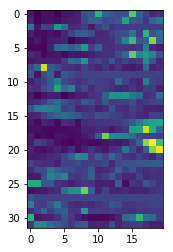

In [42]:
plt.imshow(att_seqs[:, 0])

In [73]:
pretrain_attention_discr_loss = []

In [93]:
for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=15000, max_len=seq_len):
    err = attention_discriminator.train_step(bx, by, respondent, 20)
    pretrain_attention_discr_loss.append(err)
    print("%.5f"%err)

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


45.21070
37.41234
40.79372
38.87643
41.50592
41.54293
40.37329
36.68286
41.82545
42.08524
45.68925
36.50140
33.86416
38.55825
40.43900
38.95137
43.49425
45.41165
40.43970
44.95321
39.27753
42.53679
41.26587
37.74017
41.13825
38.34433
42.16132
40.53318
36.61463
39.77700
38.35924
43.18003
39.08480
41.12815
41.13782
38.94044
42.27779
42.29353
39.46774
42.02230
40.48825
41.77866
39.02364
39.84501
36.71781
38.04281
41.97009
38.01809
38.21240
43.89863
40.41682
36.34694
40.96124
42.45418
43.89456
36.21869
41.98783
39.73675
40.89252
39.95551
38.74763
41.30737
39.41623
36.14894
41.70383
37.78809
37.44706
41.72820
41.84645
41.04699
42.15232
35.18367
42.88710
44.07101
41.13539
39.86529
38.72569
34.63213
39.21137
40.49435
38.98818
37.28667
37.96075
35.53314
42.71462
40.25858
43.32005
35.78250
39.60296
41.85965
41.67739
37.18393
40.78563
39.70316
39.96709
40.56879
39.75954
38.28834
44.88572
38.31922
40.56928
36.70842
37.69307
36.73157
40.12769
39.57655
36.10027
42.09204
40.71988
39.66067
41.65667
4

KeyboardInterrupt: 

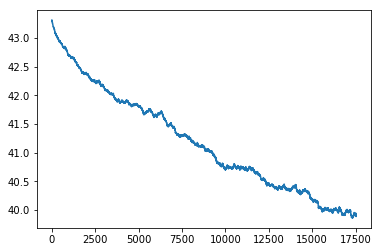

In [94]:
plot_smoothed(pretrain_attention_discr_loss, n=1000)

In [216]:
from agentnet.utils.persistence import save, load
save(attention_discriminator.recurrence, 'pretrain_att_discr_ent2.pkl')

attention sum loss

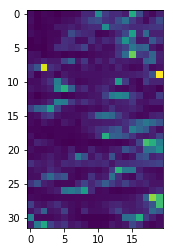

In [95]:
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
plt.imshow(att_seqs[:, 0])

С необученными эмбеддингами имен в общем пространстве:

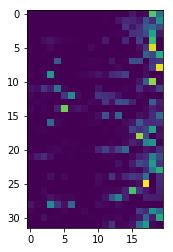

In [254]:
att_seqs4 = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
plt.imshow(att_seqs4[:, 0])

In [47]:
from termcolor import colored

def phrase_from_idx(idxs, crop_by_eos=False):
    if crop_by_eos and EOS_ix in idxs:
        idxs = idxs[:list(idxs).index(EOS_ix)]
        
    phrase_tokens = map(tokens.__getitem__, idxs)
    return phrase_tokens


def print_phrase_and_attention(phrase, attention):
    low = np.percentile(attention, 50.)
    medium = np.percentile(attention, 70.)
    high = np.percentile(attention, 80.)
    plt.imshow(attention);
    plt.show()
    high_att_idxs = np.where(attention[0] >= high)[0]
    prev_idx = 0
    for idx in high_att_idxs:
        print ' '.join(phrase_from_idx(phrase[prev_idx:idx])),
        print colored(phrase_from_idx([phrase[idx]])[0], 'red'),
        prev_idx = idx + 1
    print ' '.join(phrase_from_idx(phrase[prev_idx:]))
    #print ' '.join(phrase_from_idx(phrase))

Test on names

0.300507


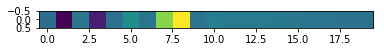

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  mark , mark , mark , you must remove your powers !


In [221]:
name_id = 439
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
print gen_reward[0, -1, 1]
print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
print "GENERATED: ", gen_answer

Rewards distribution

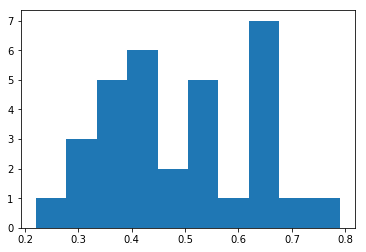

In [222]:
plt.hist(gen_rewards[:, -1, 1]);

0.580203


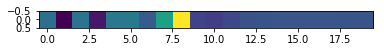

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  baptize ta , l . c . o . broflovski .


In [48]:
name_id = 439
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
print gen_reward[0, -1, 1]
print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
print "GENERATED: ", gen_answer

In [121]:
names[439]

'manson'

0.543448


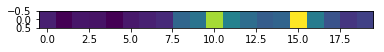

mom ! _EOS_ kyle ! _EOS_ i should have known they  were crab people . they  tried this before with
REAL:  so now , can you
GENERATED:  are you sure ? come on , this bff , david blaine is drinking tea ?
0.674853


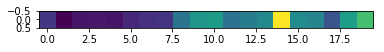

ike ! you are no longer to watch that stupid little youtube _UNK_ asshole ! do you understand ?  ! 
REAL:  and they smell like soap .
GENERATED:  no no no . independent films are made at their favorite superhero movies .
0.431099


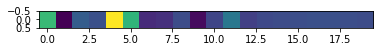

 wait ! i ' ll  fight ! _EOS_ tomorrow ? _EOS_ okay . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  craig , what the hell are you doing home ? ! you ' re supposed to be out fighting tweek
GENERATED:  listen , the graphics on the phone have really real consequences
0.44142


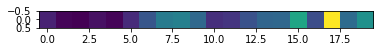

yes . _EOS_ let ' s go make things out of egg cartons . _EOS_ oooh , yeah . i 
REAL:  yeess .
GENERATED:  ooh , look what we got ' em .
0.35782


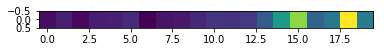

all right all right , fine ! _EOS_ could you spare some change , sir  ? _EOS_ _UNK_ !  _EOS_ 
REAL:  i ' ve dissected several homeless to see what make them tick . their anatomy is shockingly similar to ours
GENERATED:  what the hell are you doing ?
0.417008


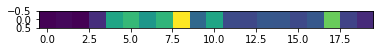

oh shit . who had the ticket stub  ? _EOS_ it was such a long time ago ! _EOS_ wu
REAL:  don ' t need the ticket stub ? ? are you high ? ? how else do i know you
GENERATED:  butters ?
0.528878


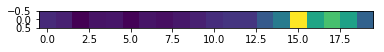

peter nelson ? _EOS_ yes ? _EOS_ brandon carlile , reporter , spin magazine . i  understand  you  work at
REAL:  yeah , that ' s right .
GENERATED:  hey stan , how did -
0.60114


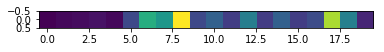

mingie , what ' re you doin  '  ? _EOS_ gettin ' ou ' a here gary ! one way
REAL:  shut up ! shut up , you miserable old cow , or so help me i ' ll blow your
GENERATED:  you don ' t want the girls back to their younger adults -
0.118277


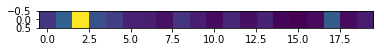

well ,  he  _EOS_ mr . garrison , i will remind you that we are in court ! _EOS_ okay
REAL:  principal victoria , were you aware that my client was being harassed at your school ?
GENERATED:  as soon as the election ' s run over , boys , you go ahead and ' yo ' ass
0.567022


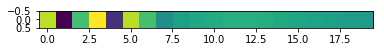

 eeewww ! _EOS_ hey ! _EOS_  sorry . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  well , why don ' t we just explore our sexuality ?
GENERATED:  wait up .
0.240307


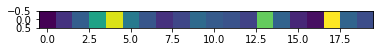

we are honored to  have creators in our kingdom . _EOS_ now , good news , everyone ! these boys
REAL:  well he said there was gonna be a - . . . that there was . . . gonna be
GENERATED:  those ethiopians should live out in south park ' s park .
0.51924


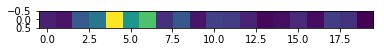

you don ' t  know  anything  ! _EOS_ i ' ve been wanting to stop going to those places ,
REAL:  it just . . . it started as some curiosity on the internet . i would chat with other married
GENERATED:  it ' s really great seeing you again for the holidays !
0.613946


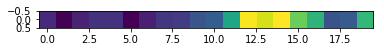

yeah ! this is bullshit ! _EOS_ together , we ' re gonna  learn  what  makes us angry , okay
REAL:  rook ! _UNK_ somebody ordereduh shitty beef , anduh complain because they say they ordereduh shitty shrimp , it '
GENERATED:  ' cause you think we what you have , too , don ' t you , dude ? we '
0.409537


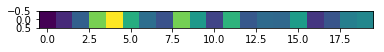

we ' re gonna  charge the front door and go get it . _EOS_ no you ' re not .
REAL:  time out , kid ! we say you can ' t charge the front door , and you have to
GENERATED:  did you get it ? !
0.130712


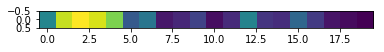

well ,  the  reason  i ' m calling is that butters is supposed to go see his aunt nellie in
REAL:  oh , but i suppose it would be good for him . yes , of course he can go .
GENERATED:  well what about the time ? passed ? should i be going on easter ?
0.53989


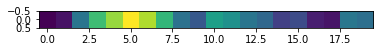

an absolutely gorgeous gun  ,  david  . _EOS_ the playful and lovely australian _UNK_ owned by father maxi . _EOS_
REAL:  that ' s a favorite of the crow here . always a favorite at these shows .
GENERATED:  here it is ! here we go !
0.469232


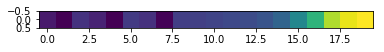

oh ! _EOS_ die ! _EOS_ ow ! _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
REAL:  get out !
GENERATED:  _UNK_ !
0.333221


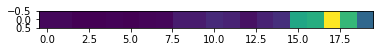

oh . . . oohhhh . _EOS_ it is lying , butters . your parents lied  to  you  and my
REAL:  who ' s that ?
GENERATED:  sure these are a bunch of information you have at your girlfriend alexandra
0.491901


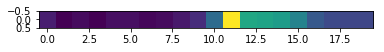

dad ? dad ? _EOS_ staaan . _EOS_ i know you do  ,  dad  . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  augh ! aaaaaaaaaaaaaaaaaaa . . .
GENERATED:  did you know that being your boyfriend used to be a tobacco company long enough to only know about 9
0.45303


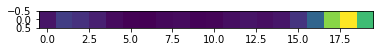

terrorists have just attacked . . . our imagination . _EOS_ if the terrorists blow that barrier  ,  all  the 
REAL:  no ! !
GENERATED:  impossible !
0.545603


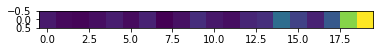

ms . claridge , you all right ? _EOS_ can kyle come out and play ? _EOS_ oh  ,  kyle 
REAL:  thank you , ma ' am .
GENERATED:  but it can ' t work .
0.780225


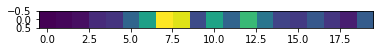

now , what seems to be the problem  ? _EOS_ aw , i just hit my nose playing dodgeball .
REAL:  _UNK_ ! !
GENERATED:  don ' t worry , muhammad may be fixed and trouble . we ' ll make you fly . soon
0.500891


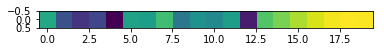

. . . how ? _EOS_ boy band . _EOS_ boy band ? _EOS_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
REAL:  boy band .
GENERATED:  we aren ' t doing too old for parents , we had nothing to do . what do you mean
0.44606


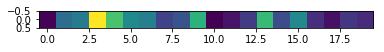

howdy ho , boys  . _EOS_ mr . hankey ? _EOS_ gosh , you boys smell like flowers . _EOS_
REAL:  you ' re not the real mr . hankey .
GENERATED:  don ' t you _UNK_ their _UNK_ ?
0.789896


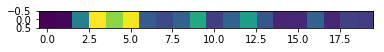

yes , you '  re  right , kyle . i ' m sure that _EOS_ your attention , please .
REAL:  kyle broflovski to the principal ' s office . please . _UNK_ ?
GENERATED:  this is poetic _UNK_ ? you ' re gay ? let ' s do jokes out . cheers and fags
0.251142


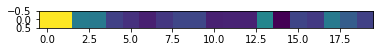

 aw  ,  come on , dude . let her try . _EOS_ no way ! _EOS_ come on , cartman
REAL:  okayokay , fine .
GENERATED:  you know what you see as now , evil spark .
0.372145


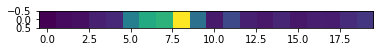

remember , kids , if you  smoke  ,  you could grow up to be a failure . _EOS_ worse yet
REAL:  yeah , because if you don ' t smoke , you can grow up to be -
GENERATED:  really ? ?
0.498542


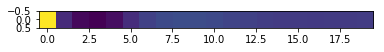

 _EOS_ _EOS_ _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  
GENERATED:  
0.775131


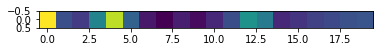

 ooooo . _EOS_ so  you . . . remarried . _EOS_ yes , lorry . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  larry !
GENERATED:  yes . old chap can only tell us for good stories . now it ' s been done .
0.451538


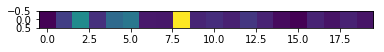

i beat out your fat  ass , cartman ! _EOS_ all students trying out for the all - state team
REAL:  all right boys , now you ' re all here because you ' re the best of the best .
GENERATED:  my job is to always put you up to those best things , to make sure the world enough !
0.596909


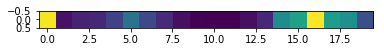

 hey ! _EOS_ ( well , . . . . . . and i can '  t  take any of
REAL:  don ' t give up on faith hilling , kenny . don ' t you give up on her .
GENERATED:  hello . hello there .
0.544237


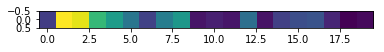

did you  get  to  any dirty parts yet ? _EOS_ no , it ' s still just some whiny ,
REAL:  i know . i ' m almost at the end and there ' s nothing . [ the door opens
GENERATED:  me no twerps .


In [50]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], np.zeros(one_batch[0].shape[0], dtype='int32'), 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, :, 1]
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i, -1]
    print_phrase_and_attention(one_batch[0][i], att_seqs[i:i+1, 0])
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

0.646619


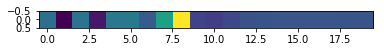

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  my name is dr . biber .
0.386294


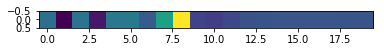

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  bye - bye , precious .
0.280729


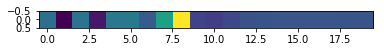

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  my children , mr . jefferson says you already made a sex doll the school nurse gollum has _UNK_ it
0.535254


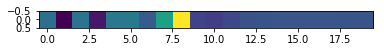

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  trent boyett !
0.325994


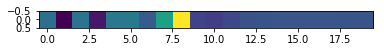

hello _EOS_ hello _EOS_ what  is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  very well .


In [51]:
for i in range(5):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, -1, 1]
    print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
    print "GENERATED: ", gen_answer

Дообучение еще немного

0.565307


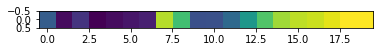

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
GENERATED:  kyle ? kyle !


In [97]:
name_id = 439
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
print gen_reward[0, -1, 1]
print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
print "GENERATED: ", gen_answer

0.670255


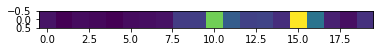

mom ! _EOS_ kyle ! _EOS_ i should have known they  were crab people . they  tried this before with
REAL:  so now , can you
GENERATED:  these could in quite a handy when aggghhh carlile musicals something in their vomit !
0.418673


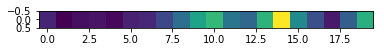

ike ! you are no longer to watch that stupid little youtube _UNK_ asshole  ! do you understand ? ! 
REAL:  and they smell like soap .
GENERATED:  stay in touch with you ?
0.438657


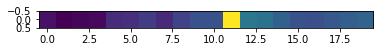

wait ! i ' ll fight ! _EOS_ tomorrow ? _EOS_ okay  .  _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ 
REAL:  craig , what the hell are you doing home ? ! you ' re supposed to be out fighting tweek
GENERATED:  you go this way , cartman ! i ' ll tell you all about yourself !
0.685884


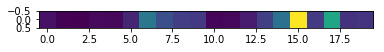

yes . _EOS_ let ' s go make things out of egg cartons . _EOS_  oooh , yeah . i
REAL:  yeess .
GENERATED:  shhhh .
0.54921


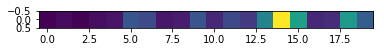

all right all right , fine ! _EOS_ could you spare some change ,  sir  ? _EOS_ _UNK_ ! _EOS_
REAL:  i ' ve dissected several homeless to see what make them tick . their anatomy is shockingly similar to ours
GENERATED:  what are you talking about ?
0.510229


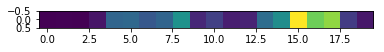

oh shit . who had the ticket stub ? _EOS_ it was such a long time  ago  ! _EOS_ wu
REAL:  don ' t need the ticket stub ? ? are you high ? ? how else do i know you
GENERATED:  hey . you okay ?
0.44259


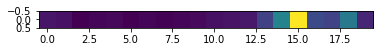

peter nelson ? _EOS_ yes ? _EOS_ brandon carlile , reporter , spin magazine .  i  understand you work at
REAL:  yeah , that ' s right .
GENERATED:  yeah , that ' s right .
0.200182


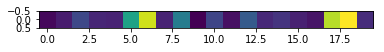

mingie , what ' re you  doin ' ? _EOS_ gettin ' ou ' a here gary !  one way
REAL:  shut up ! shut up , you miserable old cow , or so help me i ' ll blow your
GENERATED:  take that and go run out of the _UNK_ . if you try this way , then me alone will
0.530387


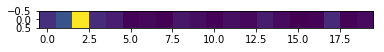

 well  ,  he  _EOS_ mr . garrison , i will remind you that we are in court ! _EOS_ okay
REAL:  principal victoria , were you aware that my client was being harassed at your school ?
GENERATED:  when butters does
0.357262


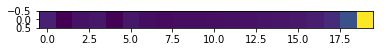

 eeewww ! _EOS_ hey ! _EOS_ sorry . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_ 
REAL:  well , why don ' t we just explore our sexuality ?
GENERATED:  sorry .
0.264578


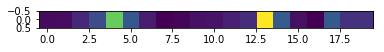

we are honored to have creators in our kingdom . _EOS_ now , good  news , everyone ! these boys
REAL:  well he said there was gonna be a - . . . that there was . . . gonna be
GENERATED:  it ' s actually really great having the union back , to be able to ' hallelujah and see it
0.00950142


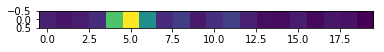

you don ' t know  anything  ! _EOS_ i ' ve been wanting to stop going to those places ,
REAL:  it just . . . it started as some curiosity on the internet . i would chat with other married
GENERATED:  what if i never had a man , my father was a non - caring person like you ?
0.497858


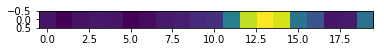

yeah ! this is bullshit ! _EOS_ together , we ' re  gonna  learn  what makes us angry , okay
REAL:  rook ! _UNK_ somebody ordereduh shitty beef , anduh complain because they say they ordereduh shitty shrimp , it '
GENERATED:  
0.532768


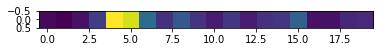

we ' re gonna charge  the  front door and go get it . _EOS_ no you ' re not .
REAL:  time out , kid ! we say you can ' t charge the front door , and you have to
GENERATED:  hey ! uh you got me .
0.167544


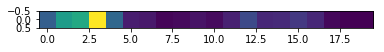

well ,  the  reason  i ' m calling is that butters is supposed to go see his aunt nellie in
REAL:  oh , but i suppose it would be good for him . yes , of course he can go .
GENERATED:  well ? what ' s wrong , sweetie ? are you really gettin ' miserable at best to keep your
0.52161


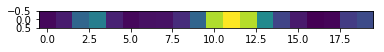

an absolutely gorgeous gun , david . _EOS_ the playful and  lovely  australian  _UNK_ owned by father maxi . _EOS_
REAL:  that ' s a favorite of the crow here . always a favorite at these shows .
GENERATED:  chef ! this is where all our money gets burned by _UNK_
0.217214


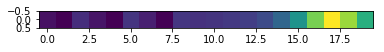

oh ! _EOS_ die ! _EOS_ ow ! _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
REAL:  get out !
GENERATED:  ! right there ! it ' s okay all this time !
0.809645


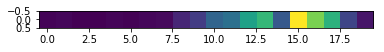

oh . . . oohhhh . _EOS_ it is lying , butters . your parents lied  to  you and my
REAL:  who ' s that ?
GENERATED:  because it was all two four and the five , four together and five all the other kids ' ve
0.167136


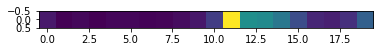

dad ? dad ? _EOS_ staaan . _EOS_ i know you do  ,  dad  . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  augh ! aaaaaaaaaaaaaaaaaaa . . .
GENERATED:  no ! you don ' t know what you ' re talking about !
0.539768


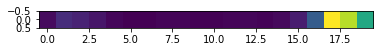

terrorists have just attacked . . . our imagination . _EOS_ if the terrorists blow that barrier  ,  all  the 
REAL:  no ! !
GENERATED:  mother !
0.605828


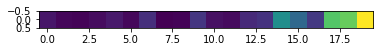

ms . claridge , you all right ? _EOS_ can kyle come out and play ? _EOS_ oh  ,  kyle 
REAL:  thank you , ma ' am .
GENERATED:  oh my god , you know . that i used to study behind the theater . now i can hide
0.476279


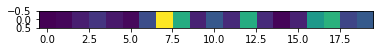

now , what seems to be the problem  ? _EOS_ aw , i just hit my nose playing dodgeball .
REAL:  _UNK_ ! !
GENERATED:  what ?
0.41377


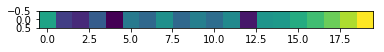

. . . how ? _EOS_ boy band . _EOS_ boy band ? _EOS_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
REAL:  boy band .
GENERATED:  the band , dude . play tv ? bands at band practice ?
0.542468


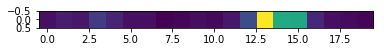

howdy ho , boys . _EOS_ mr . hankey ? _EOS_ gosh ,  you  boys  smell like flowers . _EOS_
REAL:  you ' re not the real mr . hankey .
GENERATED:  crap , these are
0.294203


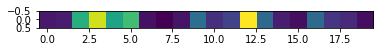

yes , you  ' re right , kyle . i ' m sure that _EOS_ your attention , please .
REAL:  kyle broflovski to the principal ' s office . please . _UNK_ ?
GENERATED:  kyle broflovski to school , or i ' m for c - c - c - late .
0.305387


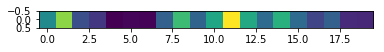

aw , come on , dude . let her try . _EOS_ no way ! _EOS_ come on , cartman
REAL:  okayokay , fine .
GENERATED:  hey ! open your mouths and just open your potato salad !
0.711359


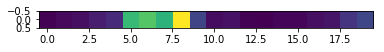

remember , kids , if you  smoke  ,  you could grow up to be a failure . _EOS_ worse yet
REAL:  yeah , because if you don ' t smoke , you can grow up to be -
GENERATED:  that sick kid and he ' d kick his ass . that ' s what the mike students are really
0.522393


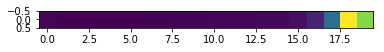

_EOS_ _EOS_ _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_  _PAD_  _PAD_ 
REAL:  
GENERATED:  
0.554054


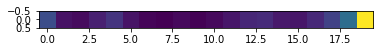

 ooooo . _EOS_ so you . . . remarried . _EOS_ yes , lorry . _EOS_ _PAD_ _PAD_  _PAD_  _PAD_ 
REAL:  larry !
GENERATED:  . . . no , geoff . . .
0.471098


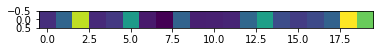

i beat out your fat ass , cartman ! _EOS_ all students trying out for the all - state  team 
REAL:  all right boys , now you ' re all here because you ' re the best of the best .
GENERATED:  all right . now , here ' s your " christmas ' s anniversary box , " whatever .
0.120684


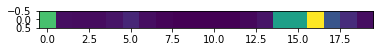

 hey ! _EOS_ ( well , . . . . . . and i can  '  t take any of
REAL:  don ' t give up on faith hilling , kenny . don ' t you give up on her .
GENERATED:  yah it was craig and i can ' t wait for him to see my car !
0.53708


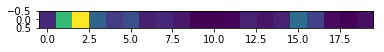

did you  get  to any dirty parts yet ? _EOS_ no , it ' s still just some whiny ,
REAL:  i know . i ' m almost at the end and there ' s nothing . [ the door opens
GENERATED:  you wendy ?


In [98]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], one_batch[2], 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, :, 1]
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i, -1]
    print_phrase_and_attention(one_batch[0][i], att_seqs[i:i+1, 0])
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

0.640909


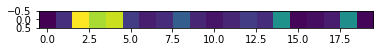

why are you so obsessed with cartman ' s trapper keeper , bill cosby ? _EOS_ bill cosby ? _EOS_
REAL:  well , i knew you weren ' t bill cosby !
GENERATED:  well , it ' s been a sophisticated project and its only work is done . the design is integrity
0.494966


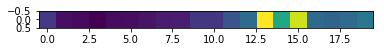

ahhh . _EOS_ oh . _EOS_ sheila , could you pass me the dead fetus ? _EOS_ _PAD_ _PAD_ _PAD_
REAL:  ow !
GENERATED:  move along , folks . we have a new condition soon .
0.688524


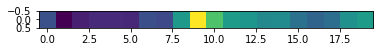

awkwaaard ! _EOS_ and this june , funnybot shows off  his range by playing every role in . . .
REAL:  pass them yourself .
GENERATED:  pass it through !
0.781413


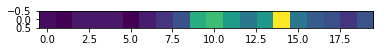

no ! allied atheist alliance ! that way it has three a ' s ! that is the logical choice
REAL:  i have to get out of here ! why is everyone in my past so stupid that they think i
GENERATED:  hey , look over , don ' t you get it , attitude or will you guys ? ! are
0.774498


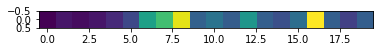

oh , god , it ' s horrible ! _EOS_ that ' d disgusting , dude ! _EOS_ god ,
REAL:  we have to go to butters ' or cartman ' s house ! we have nowhere else to go !
GENERATED:  we found companies that tried to screw us off , made them responsible for bigger fans !
0.443952


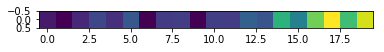

no ! no , no boys ! aw goddammit ! _EOS_ this is hbc news . a right - to 
REAL:  you bastards !
GENERATED:  no , aboot what ?
0.542417


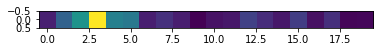

here carol ,  i think it ' s your boy . _EOS_ oh thanks . what is it stanley -
REAL:  stanley , honey , you need to leave mommy alone , i ' m doing something very , very important
GENERATED:  turning , channel or approaching !
0.412841


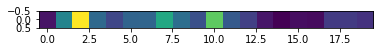

what do you guys wanna do first ? i hear they have a new inner tube slide . _EOS_ no
REAL:  you know , there ' s always like five or six minorities wearing their t - shirts in the wave
GENERATED:  did you ever have any adult friends ?
0.826511


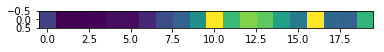

what ? _EOS_ mayor , this is a jakovasaur . a live one has never been seen . _EOS_ oh
REAL:  incredible .
GENERATED:  let ' s go from now on ! alter america sees a hero . no rewards for world .
0.356693


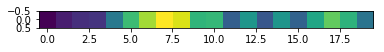

oh , jeez , you wouldn ' t  have believed how angry i was when teacher said i had to
REAL:  and sometimes mommies do things that seem hurtful to their babies , but it ' s really for the best
GENERATED:  give it up , president the jews !
0.541994


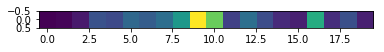

oprah ' s got egg all over her face !  she ' ll have to retire ! _EOS_ it '
REAL:  sure . and ' er gary . we did it , mate !
GENERATED:  that ' s no problem !
0.442352


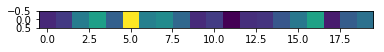

so what you do , see , is wait for a car to drive by that big pine tree .
REAL:  you try it , bebe .
GENERATED:  use the chicken . use it in human kindness .
0.618033


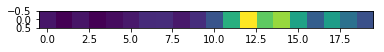

stan ! stan ! oh . okay , uh , you you might be wondering why butters has a future
REAL:  oh . . . well . . . son , we ' ve just been trying to make sure you
GENERATED:  wow , that ' s a great idea you had on twitter ? what ' s your bp ?
0.434616


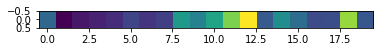

alright ! _EOS_ they were so scared , i ' m sure they ' ll never be back ! _EOS_
REAL:  what ?
GENERATED:  what ? a police came ?
0.430695


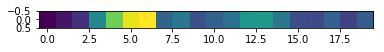

no , that ' s impossible  ! _EOS_ little boy , are you sure you haven ' t taken it
REAL:  kyle ? kyle !
GENERATED:  kyle ?
0.471726


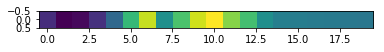

hallo ? _EOS_ who ith thith ? _EOS_ this is  gary . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  gary who ? ! what is your last name ? !
GENERATED:  get down to your stations !
0.504002


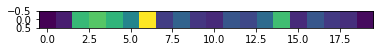

think about it , guys . if somebody kills sarah jessica parker , then they ' ll assume that somebody
REAL:  shut up , cartman ! just face it . we lost this one .
GENERATED:  
0.239116


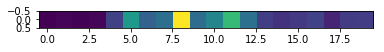

sir , we ' ve got confirmation . there ' s two black guys in the upstairs of the house
REAL:  yehah ? hang on ! mitch !
GENERATED:  do you really think the history gum people will give you attention to big canadians ?
0.328405


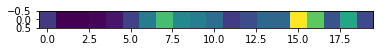

what ? _EOS_ timmy and i are competing in a variety of events . _EOS_ yeah  sure , we '
REAL:  yeah , that ' d be cool .
GENERATED:  yeah sure , that ' d be good or not south of town !
0.439149


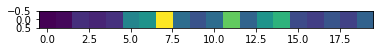

but jews can ' t play basketball ! _EOS_ kyle , you ' d better stop being anti - semitic
REAL:  oh , that does it !
GENERATED:  oh , that does it !
0.577949


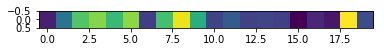

randy , what is this ? _EOS_ hey ! you are now under the authority of the aarp ! _EOS_
REAL:  dad , what are you doing ? ?
GENERATED:  it ' s your choice , don ' t .
0.629648


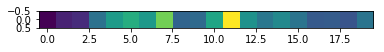

no he ' s not . _EOS_ i don ' t know . _EOS_ i just need to explain things
REAL:  yeah , i was watching with my whole family . and then we saw all the _UNK_ this morning in
GENERATED:  all the time we saw here is an abomination of mint ! the muslim things inside your muslim dream underwear
0.123943


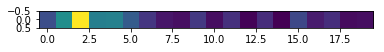

well ,  i ' m afraid i can ' t give it to you , because then you wouldn '
REAL:  . . . yeah ?
GENERATED:  all right good job , fatass ! come on ! everyone up _UNK_ ' my evil and - big head
0.164227


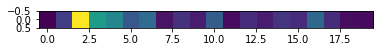

what did they  do you you ? at that camp ? _EOS_ what do you mean ? just the usual
REAL:  that ' s ridiculous . i ' m not anything . i don ' t fit in anywhere . i
GENERATED:  that ' s not cool . we ' re basing the _UNK_ them for you .
0.565291


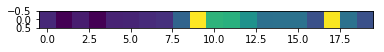

mom ! doorbell ! _EOS_ wait , before you do , pull my thumb . _EOS_ mom ! answer the
REAL:  hey phillip , guess what ?
GENERATED:  what is the gas source ?
0.674226


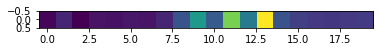

no way ! the bitches from cirque du _UNK_ ! _EOS_ yeah . they ' re quintuplets from romania .
REAL:  ve are twins , except there are five of us instead of two .
GENERATED:  let ' s all ginger kids in south park are recording a reading of the students ' win .
0.476206


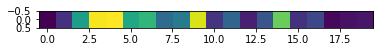

oohh , morning ,  hum , _UNK_ . _UNK_ ! _EOS_ okay , asshole ! give me back my kidney
REAL:  it ' s mine ! not yours , mine ! give it back right now , or there ' s
GENERATED:  the only thing the humans have to do change their life than you , you can get tobacco companies themselves
0.506104


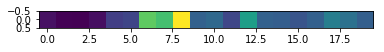

yeah . but i have to say , i feel a lot better now . _EOS_ i know what you
REAL:  i didn ' t feel bad before , but now i just feel terrible .
GENERATED:  what we going to do now ?
0.601103


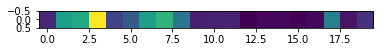

can you believe it , boys ? ! we ' re playing in the state championship game ! _EOS_ we
REAL:  well , then your whole season starts over , but on the national circuit ! you get to spend your
GENERATED:  no game on social circuit ! you must feel pretty goddamned right now when it comes to
0.238989


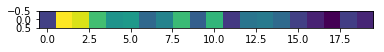

i hope  for your sake that ' s true . you ' ve never thrown a party of this magnitude
REAL:  satan _UNK_ us .
GENERATED:  we ' re going to use all the internet to help her get out of town .
0.630551


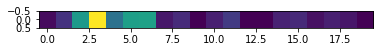

i think this will be very good for you _EOS_ but we don ' t even _EOS_ and that '
REAL:  please , mr . mackey , we ' ll be good . don ' t send us to that ole
GENERATED:  we ' re trying to tell you something , something . . . even people with attention . prepare for
0.560772


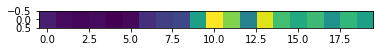

. . . chef ? ? a - are you okay ? _EOS_ i want to stick my balls inside
REAL:  i ' m gonna make love to your asshole , children .
GENERATED:  they ' re about to kick your ass .


In [246]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], np.zeros(len(bx), dtype='int32'), 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, :, 1]
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i, -1]
    print_phrase_and_attention(one_batch[0][i], att_seqs[i:i+1, 0])
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

mean loss

0.556569


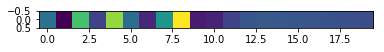

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  it just isn ' t very nice . i just need to ve a nice little . . .
0.596792


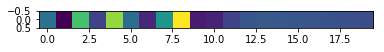

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  tc marsh .
0.464669


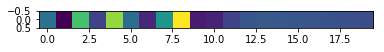

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  wull , why are you doing this ?
0.444882


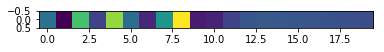

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  my name is father maxi . i
0.438679


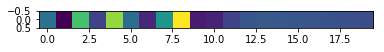

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  kyle broflovski .


In [287]:
for i in range(5):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, -1, 1]
    print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
    print "GENERATED: ", gen_answer

0.56306


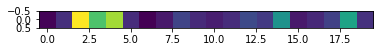

why are you so obsessed with cartman ' s trapper keeper , bill cosby ? _EOS_ bill cosby ? _EOS_
REAL:  well , i knew you weren ' t bill cosby !
GENERATED:  well , it turns out students , nasty hilling , is also considered the fastest negotiator for the filmore of
0.407778


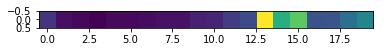

ahhh . _EOS_ oh . _EOS_ sheila , could you pass me the dead fetus ? _EOS_ _PAD_ _PAD_ _PAD_
REAL:  ow !
GENERATED:  back in of the early minute an orderly fashion is our first night of lawyer predator .
0.590147


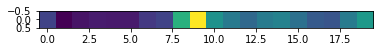

awkwaaard ! _EOS_ and this june , funnybot shows  off his range by playing every role in . . .
REAL:  pass them yourself .
GENERATED:  pass them yourself .
0.699889


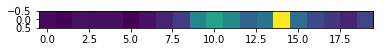

no ! allied atheist alliance ! that way it has three a ' s ! that is the logical choice
REAL:  i have to get out of here ! why is everyone in my past so stupid that they think i
GENERATED:  for one new child to get everyone to destroy the great one , we make everyone understand that we '
0.785337


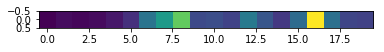

oh , god , it ' s horrible ! _EOS_ that ' d disgusting , dude ! _EOS_ god ,
REAL:  we have to go to butters ' or cartman ' s house ! we have nowhere else to go !
GENERATED:  we know that this is even more complicated than it seems : the judge wouldn ' t car . it
0.357774


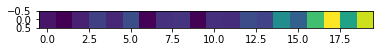

no ! no , no boys ! aw goddammit ! _EOS_ this is hbc news . a right - to 
REAL:  you bastards !
GENERATED:  do you think we ' re getting our shot to the principal ? !
0.361799


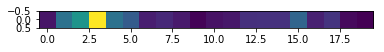

here carol ,  i think it ' s your boy . _EOS_ oh thanks . what is it stanley -
REAL:  stanley , honey , you need to leave mommy alone , i ' m doing something very , very important
GENERATED:  dinner is playing wide and what about pot , some such for girls like hope ?
0.199881


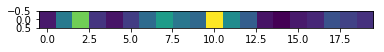

what do you guys wanna do first ? i hear they have a new inner tube slide . _EOS_ no
REAL:  you know , there ' s always like five or six minorities wearing their t - shirts in the wave
GENERATED:  now children , as children do , with the screening of the focused on the other side , our top
0.200228


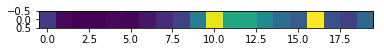

what ? _EOS_ mayor , this is a jakovasaur . a live one has never been seen . _EOS_ oh
REAL:  incredible .
GENERATED:  the time border came from us , it appears to have been steve . he ' s been reading through
0.591092


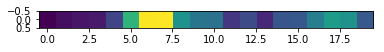

oh , jeez , you wouldn '  t have believed how angry i was when teacher said i had to
REAL:  and sometimes mommies do things that seem hurtful to their babies , but it ' s really for the best
GENERATED:  give him your phone , mr white .
0.613383


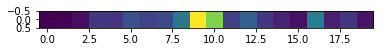

oprah ' s got egg all over her face !  she ' ll have to retire ! _EOS_ it '
REAL:  sure . and ' er gary . we did it , mate !
GENERATED:  make love to that terrance and phillip terrance and phillip _UNK_ in romania . remember no one chef was a
0.718785


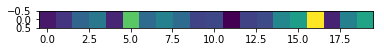

so what you do , see , is wait for a car to drive by that big pine tree .
REAL:  you try it , bebe .
GENERATED:  what do you want it for ?
0.610062


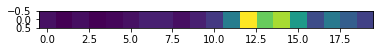

stan ! stan ! oh . okay , uh , you you might be wondering why butters has a future
REAL:  oh . . . well . . . son , we ' ve just been trying to make sure you
GENERATED:  well . . . there ' s you . see there ' s something i need to know about ih
0.476048


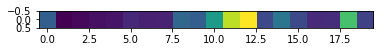

alright ! _EOS_ they were so scared , i ' m sure  they ' ll never be back ! _EOS_
REAL:  what ?
GENERATED:  why couldn ' t we just throw the key to the four of you ?
0.617938


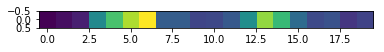

no , that ' s impossible  ! _EOS_ little boy , are you sure you haven ' t taken it
REAL:  kyle ? kyle !
GENERATED:  all right , the monster nambla showed up outside to get to listen to you . the holiday year is
0.64593


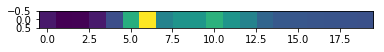

hallo ? _EOS_ who ith thith ? _EOS_ this is gary . _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  gary who ? ! what is your last name ? !
GENERATED:  put your gun in the car , put in the gun !
0.704385


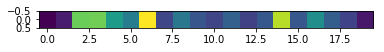

think about it , guys . if somebody kills sarah jessica parker , then they ' ll assume that somebody
REAL:  shut up , cartman ! just face it . we lost this one .
GENERATED:  calm down . we don ' t have time for a bit . looks like nelson has gone over one
0.410721


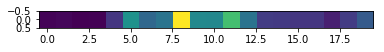

sir , we ' ve got confirmation . there ' s two black guys in the upstairs of the house
REAL:  yehah ? hang on ! mitch !
GENERATED:  you call it " " fuckin ' indian ! "
0.508307


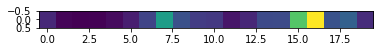

what ? _EOS_ timmy and i are competing in a variety of events . _EOS_ yeah  sure , we '
REAL:  yeah , that ' d be cool .
GENERATED:  yeah sure . wouldn ' t it be nice to have this kind of year ?
0.895345


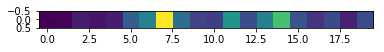

but jews can ' t play basketball ! _EOS_ kyle , you ' d better stop being anti - semitic
REAL:  oh , that does it !
GENERATED:  oh , about what an older child is now having puberty trapped in grows from a country and child bullying
0.499807


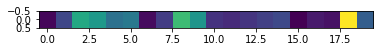

randy , what is this ? _EOS_ hey ! you are now under the authority of the aarp ! _EOS_
REAL:  dad , what are you doing ? ?
GENERATED:  it is an ungrateful passing - law , my son . what are you doing ?
0.812598


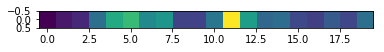

no he ' s not . _EOS_ i don ' t know . _EOS_ i just need to explain things
REAL:  yeah , i was watching with my whole family . and then we saw all the _UNK_ this morning in
GENERATED:  then we should give on it . have you ever nambla ? great - attention people . now what do
0.332081


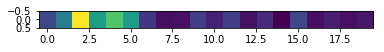

well , i ' m afraid i can ' t give it to you , because then you wouldn '
REAL:  . . . yeah ?
GENERATED:  before you get cancer , the first thing we have to do with this " denver broncos " pop the
0.486275


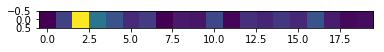

what did they  do you you ? at that camp ? _EOS_ what do you mean ? just the usual
REAL:  that ' s ridiculous . i ' m not anything . i don ' t fit in anywhere . i
GENERATED:  i told you to noo - serve them you ' re a dwarf .
0.377801


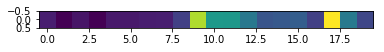

mom ! doorbell ! _EOS_ wait , before you do , pull my thumb . _EOS_ mom ! answer the
REAL:  hey phillip , guess what ?
GENERATED:  all right , comedy is what you need to be in a mascot with big your coach . you '
0.528153


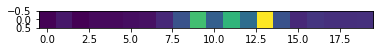

no way ! the bitches from cirque du _UNK_ ! _EOS_ yeah . they ' re quintuplets from romania .
REAL:  ve are twins , except there are five of us instead of two .
GENERATED:  when they first yup don ' t get involved . gang , they found another poor kid .
0.704652


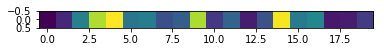

oohh , morning , hum , _UNK_ . _UNK_ ! _EOS_ okay , asshole ! give me back my kidney
REAL:  it ' s mine ! not yours , mine ! give it back right now , or there ' s
GENERATED:  it is yours ! your other hands are ours !
0.286695


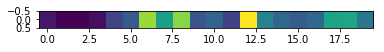

yeah . but i have to say , i feel a lot better now . _EOS_ i know what you
REAL:  i didn ' t feel bad before , but now i just feel terrible .
GENERATED:  this is the denver broncos la cucaracha line mohammad champion , and apparently , kid , these _UNK_ cast _UNK_
0.393436


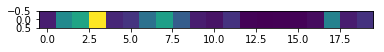

can you believe  it , boys ? ! we ' re playing in the state championship game ! _EOS_ we
REAL:  well , then your whole season starts over , but on the national circuit ! you get to spend your
GENERATED:  let ' s kill it !
0.42226


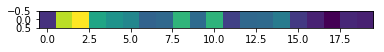

i hope  for your sake that ' s true . you ' ve never thrown a party of this magnitude
REAL:  satan _UNK_ us .
GENERATED:  wait , wait . it ' s one of the denver turkeys ' party .
0.501879


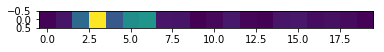

i think this will be very good for you _EOS_ but we don ' t even _EOS_ and that '
REAL:  please , mr . mackey , we ' ll be good . don ' t send us to that ole
GENERATED:  and please you call to bring jews that will bring jews together again will the very day of miss crunch
0.616187


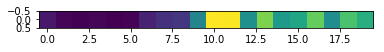

. . . chef ? ? a - are you okay  ? _EOS_ i want to stick my balls inside
REAL:  i ' m gonna make love to your asshole , children .
GENERATED:  i don ' t think so .


In [271]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], np.zeros(len(bx), dtype='int32'), 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, :, 1]
att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i, -1]
    print_phrase_and_attention(one_batch[0][i], att_seqs[i:i+1, 0])
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

In [285]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 1))
    
temperature.set_value(np.float32(1))

kyle broflovski , have you seen my paper ?
kyle broflovski .
it ' s a pretty name .
kyle broflovski , have a seat over there .
kyle broflovski , nice to meet you .


0.460211


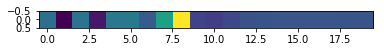

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  my name is randy marsh . i ' m r - r - confused about nice stuff like that first
0.580203


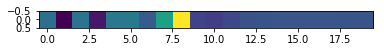

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  baptize ta , l . c . o . broflovski .
0.671239


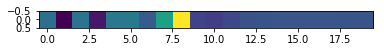

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  door will open well . it ' s super best friends ; show your support or will you stay with
0.432322


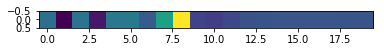

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  kyle .
0.646619


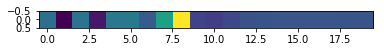

hello _EOS_ hello _EOS_ what is your name  ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
GENERATED:  my name is dr . biber .


In [40]:
for i in range(5):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, -1, 1]
    print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
    print "GENERATED: ", gen_answer

In [101]:
from agentnet.learning.generic import get_values_for_actions

class pg_trainer:    
    
    rewards = attention_discriminator.output_on_fake[:, -1, 1]
    baseline = attention_discriminator.output_on_greedy_fake[:, -1, 1]

    advantage = rewards - baseline

    policy = get_values_for_actions(generator.probs, generator.out)
    #policy = T.maximum(policy, 1e-10)
    log_policy = T.log(policy)
    neg_entropy = (generator.probs * T.log(generator.probs)).sum(axis=-1)

    loss = ((-log_policy * advantage[:,None] + 0.01 * neg_entropy) * generator.mask).sum() / generator.mask.sum()

    grads = T.grad(loss, generator.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = generator.auto_updates + generator.greedy_auto_updates
    updates += lasagne.updates.adam(grads, generator.weights, learning_rate=1e-4) 
    
#     f = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], generator.out, 
#                    generator.auto_updates, allow_input_downcast=True)

    train_step = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], loss,
                                 updates=updates,
                                 allow_input_downcast=True)

In [102]:
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)

conversation_names = set(names) & set(tokens)

conversation_name_idxs = map(name_to_ix.get, conversation_names)
conversation_token_idxs = map(token_to_ix.get, conversation_names)

name_batch_repeated = np.repeat(name_batch, len(conversation_names), axis=0)

def accuracy_in_names():
    #model_answers = generator.generate(name_batch_repeated, conversation_name_idxs, 20, latent_for_name_batch)
    model_answers = [generator.generate(name_batch, [name_idx], 20) 
                                        for name_idx in conversation_name_idxs]
    def crop_by_eos(answer):
        if  EOS_ix in answer:
            return answer[:list(answer).index(EOS_ix)]
        return answer
        
    res = map(lambda answer, name_idx: name_idx in set(crop_by_eos(answer[0])), model_answers, conversation_token_idxs)   
    matched_idxs = np.where(res)[0]
    name_idxs = [conversation_name_idxs[idx] for idx in matched_idxs]
    matched_names = [names[idx] for idx in name_idxs]
    
    matched_answers = [' '.join(phrase_from_idx(model_answers[idx][0], crop_by_eos=True)) for idx in matched_idxs] 
    return matched_names, matched_answers
    return sum(res)

In [103]:
def plot_smoothed(x, n=10):
    smoothed_x = [np.mean(x[i-n:i]) for i in range(n, len(x))]
    plt.plot(smoothed_x)

In [104]:
gen_train_errors = []
discr_train_errors = []
accuracies_in_names = []

In [105]:
for epoch in range(200):
    for _ in range(1):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=2, max_len=seq_len):
            err = pg_trainer.train_step(bx, respondent, 20)
            gen_train_errors.append(err)
        print("Gen %.5f"%err)
    for _ in range(6):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=8, max_len=seq_len):
            err = attention_discriminator.train_step(bx, by, respondent, 20)
            discr_train_errors.append(err)
        #print("Discr %.5f"%err)


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Gen -0.17828
Gen 0.47887
Gen 0.03732
Gen -0.11570
Gen 0.13739
Gen -0.06154
Gen 0.24034
Gen -0.08678
Gen 0.06567
Gen -0.04981
Gen 0.17704
Gen 0.04493
Gen -0.28015
Gen 0.10555
Gen 0.34172
Gen -0.05716
Gen 0.27269
Gen 0.21232
Gen 0.21438
Gen 0.18439
Gen 0.04233
Gen 0.23012
Gen 0.04967
Gen 0.16284
Gen 0.39753
Gen 0.10990
Gen 0.07120
Gen -0.19108
Gen 0.10930
Gen 0.01967
Gen -0.12535
Gen 0.00837
Gen -0.00087
Gen 0.12656
Gen -0.02007
Gen -0.18573
Gen -0.20585
Gen 0.06287
Gen 0.23239
Gen -0.02142
Gen -0.12052
Gen -0.06851
Gen -0.19253
Gen -0.18941
Gen 0.03741
Gen 0.02732
Gen 0.00114
Gen 0.07580
Gen 0.29254
Gen 0.20085
Gen -0.04162
Gen -0.07306
Gen 0.02694
Gen -0.04041
Gen 0.23965
Gen 0.19671
Gen 0.14064
Gen 0.05190
Gen 0.04635
Gen -0.00543
Gen -0.07702
Gen -0.01887
Gen -0.25307
Gen -0.10878
Gen -0.01473
Gen -0.16745
Gen 0.19708
Gen -0.02664
Gen 0.10732
Gen 0.21868
Gen -0.00439
Gen 0.13600
Gen -0.10160
Gen 0.06383
Gen -0.10160
Gen -0.09891
Gen -0.15906
Gen -0.04045
Gen 0.02584
Gen -0.19340
Gen 

KeyboardInterrupt: 

In [46]:
accuracy_in_names()

(['president', 'scott'],
 ["it ' s the president of wall - mart . at south park elementary . the second was a hit",
  "my name . . . called scott , but my dad isn ' t even legal anymore ?"])

In [58]:
accuracy_in_names()

(['vampir', 'everyone'],
 ['my name is vampir veronica , little guy brought in a little doll face . a new girlfriend , a',
  "it ' s all everyone . everyone write a good song , all wrassling entitled together ."])

In [60]:
accuracy_in_names()

(['cartman'],
 ["my name is eric cartman . i ' m singing about swimming lessons in another elementary school . i '"])

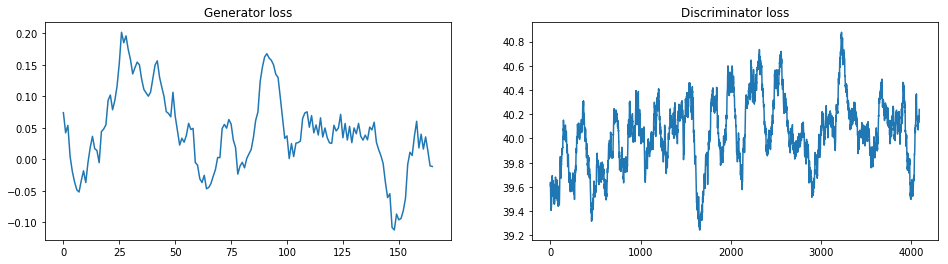

In [106]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.title("Generator loss")
plot_smoothed(gen_train_errors, n=10)
#plt.plot(gen_train_errors)
plt.subplot(1, 2, 2)
plt.title("Discriminator loss")
plot_smoothed(discr_train_errors, n=100)

In [62]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 100))
    
temperature.set_value(np.float32(1))

my name is randy marsh , and i ' m the fourth of july , and south park county sheriff
the president of the united states is on the phone for you .
my name is randy marsh , and i ' m stan marsh of the black friday .
stan marsh , a girl named _UNK_ , a _UNK_ .
my name is randy marsh , and i ' m supposed to read your favorite psalm for you .


0.435703


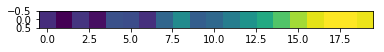

hello _EOS_ hello _EOS_ what is your name ? _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_  _PAD_ _PAD_
GENERATED:  stan marsh , ah i ' m with my friends done for about to take me to see peter panda


In [85]:
name_id = 439
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
print gen_reward[0, -1, 1]
print_phrase_and_attention(name_batch[0], att_seqs[:, 0])
print "GENERATED: ", gen_answer

In [140]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "How are you ?"], 100))
    
temperature.set_value(np.float32(1))

pessimist horsehead _Beary_ haqa _Pope_Francis_ resolute _Mrs._Tenorman_ jakovasaur wokay _al-Zawahri_ _Mona_ _Bar_Patron_1_ _Patty_ _Pizza_Man_ kiiill dofiiin ush sobered _Bradley_ eewww
freda _Center_Judge_ _Worker_4_ wugh _Mechanic_ mmmmmmmmmm _Kid_4_ weeeeee _Kid_4_ _El_Presidente_ _Darryl_Weathers_ yelper _Blond_Trekker_ _NAMBLA_Leader_ _Townsman_1_ assface _Jeff_VanVonderen_ fingerbang scrimp tutsi
_Tammy_ _Man_In_Middle_ _The_Situation_ _Therapist_ disagreeable _Whole_Foods_Rep_ _Romper_Stomper_ _Refugees_ _Lucas_ talangar sega > _Younger_Man_ _Aunt_Flo_ _Ganz_ _MC_ _Francis_ astrologer _Skynard_Man_ infusing
carlotta viviane aaaaaaaaaa medea skedaddle _Smoker_ yongee _Mephesto_ dofiiin _Meat_Loaf_ yeup _Greeley_Officer_3_ _Sgt._Yates_ caiaphas _Saddam_Hussein_ _Officer_5_ oogh _Resident_3_ _Executor_ ihatecartmanbrah
_Reporter_ sterben _Muslim_2_ _Nellie_ belarrus _Det._Jarvis_ _Bebe_ _Choir_Teacher_ _Tad_and_friends_ _Mr._Fun_ _Mike_ foolies _Inmate_ gentleness thuh maaaa hmka

### Adversarial success

In [109]:
generator.get_perplexity_fn(one_batch[0], one_batch[2], 20)

array(7.652363567378589)

In [56]:
import pickle
with open('test_batches.pcl', 'rb') as f:
    test_batches = pickle.load(f)

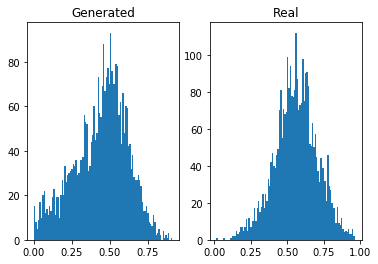

In [107]:
outs = []
real_outs = []
for bx, by, respondent in test_batches:
    outs.append(get_discr_out_on_fake(bx, respondent, 20))
    real_outs.append(get_discr_out_on_real(bx, by))
outs = np.concatenate(outs)
real_outs = np.concatenate(real_outs)

plt.subplot(1, 2, 1)
plt.title("Generated")
plt.hist(outs, bins=100);
plt.subplot(1, 2, 2)
plt.title("Real")
plt.hist(real_outs, bins=100);


In [108]:
from sklearn.metrics import roc_auc_score
roc_auc_score(len(outs) * [0] + len(real_outs) * [1], np.concatenate([outs, real_outs]))

0.6919197265625